In [1]:
import warnings
warnings.filterwarnings('ignore')

# Quelques exercices de Regression lineaires...

Notre objectif  est maintenant d'obtenir une expérience pratique et une intuition de la régression linéaire et de la régularisation. 


## Overview:

Dans ce cahier, nous introduirons la notion de régression lineaire et verrons comment améliorer l'apprentissage et la prédiction en introduisant une régularisation. Nous nous concentrerons principalement sur les applications simples de la régression linéaire: minimiser l'erreur quadratique moyenne (MSE) sur les données d'apprentissage (c'est-à-dire l'erreur intra-échantillon) et voir comment nous nous en tirerons sur les données de test (c'est-à-dire les erreurs hors échantillon). ). 

Nous allons considérer le problème de la régression des moindres carrés ordinaire dans lequel la "fonction d'erreur" est définie comme le **carré de la déviation de notre prédicteur linéaire à la réponse vraie**. Nous allons cependant compléter cette fonction d'erreur avec un régularisateur qui évite les surajustements, pour obtenir la Régularisation de Ridge (ou de Tikhonov).

Considérons des données de la forme $ (y_i, \mathbf {x} ^ {(i)}) $ où l'index $ i = 1 \ldots n $ dépasse le nombre d'exemples dans les données d'apprentissage et $ \mathbf {x} ^ {(i)} $ est un vecteur de fonction dimensionnelle $ p $. Pour faciliter la notation, il est utile de définir la matrice $ X $ des datas qui est $ n \times p $  dont les lignes, $ \textbf {x} ^ {(1)}, \cdots, \textbf { x} ^ {(n)} $, sont les exemples et les colonnes, $ \mathbf {X} _ {:, 1}, \cdots, \mathbf {X} _ {:, p} $, sont les "caractéristiques mesurées "(ie les prédicteurs).  Nous notons également le vecteur colonne dimensionnelle $ n $ de l'échantillon $ i $ as $ \mathbf {y} _i $ et le vecteur colonne dimensionnel $ p $ des paramètres de régression $ \mathbf {w} \in \mathbb {R} ^ p $.

Pour la régression des moindres carrés ordinaire (pas de régularisation), nous minimisons la fonction de coût de perte au carré:
$$
\underset{\textbf{w}\in\mathbb{R}^p}{\operatorname{min}} ||\textbf{Xw}-\textbf{y}||_2^2 = \underset{\textbf{w}\in\mathbb{R}^p}{\operatorname{min}} \,(\mathbf{Xw}-\mathbf{y})^T(\mathbf{Xw}-\mathbf{y}),
$$
ou de facon equivalente:
$$
\underset{\textbf{w}\in\mathbb{R}^p}{\operatorname{min}}   \sum_{i=1}^n (y_i -\mathbf{w}\cdot\mathbf{x}^{(i)})^2.
$$

Si le rang de la matrice est tel que $rank(\mathbf{X})=p$, namely, les prédicteurs (elements) de  $ \mathbf {X} _ {:, 1}, \cdots \mathbf {X} _ {:, p} $ sont linéairement indépendants, et il existe alors une solution unique à ce problème:
$$
\hat{\textbf{w}}= (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T \textbf{y}
$$

## Jouons d'abord avec les polynomes ##
Nous allons commencer par essayer de fitter des données que nous allons générer à l'aide de polynomes. Commençons par créer nos données. En physique, nous avons souvent des signaux sinusoïdaux avec du bruit, c'est la situation que nous allons esssayer de reproduire.

* Soit $(X,Y)$ une paire de variables aléatoires ayant les propriétés suivantes : $X$ suit une loi uniforme sur $[0,1]$ et $Y = sin(6X)+\sigma Z$ où $\sigma =0.5$ et $Z$ est une variable aléatoire indépendante de $X$ suivant une loi normale de paramètres (0,1).
* Dans le modèle précédent, si par exemple nous mesurons un signal électrique au cours du temps, les réalisations de $X$ correspondent aux instants où la mesure est faite, $Y$ correspond au résultat de la mesure, et $Z$ au bruit possible. 


***Exercice :*** Générer 400 tirages de X et Y : $(x_i,y_i)$ pour $i=1....400$, puis les tracer avec sur le même graphe la fonction $f:x \rightarrow sin(6x)$

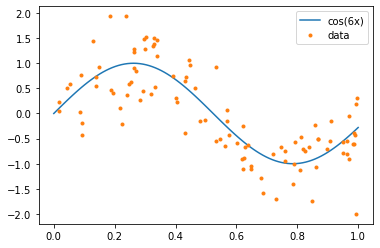

In [2]:
import numpy as np
import matplotlib.pyplot as plt

sigma = 0.5
n_values = 100

X = np.random.rand(n_values)
Y = np.sin(6*X) + sigma * np.random.randn(n_values)

x = np.linspace(0, 1, 100)
y = np.sin(6*x)

plt.plot(x, y, label='cos(6x)')
plt.plot(X, Y, '.', label='data')
plt.legend()

***Exercice : *** Séparer les données en un ensemble de test(20%) et un ensemble d'entrainement(80%)

In [3]:
n_samples_train = int(n_values*0.8)
n_samples_test = n_values - n_samples_train

X_train, y_train = X[:n_samples_train], Y[:n_samples_train]
X_test, y_test = X[n_samples_train:], Y[n_samples_train:]

Maintenant, nous allons essayer de fitter ces données précédentes avec des polynômes de différents degrés

### Fit avec un polynôme de degré 1 ###
Nous avons à notre disposition la formule du paragraphe précédent, la question est, comment mettre ce problème sous forme matricielle ? Il suffit en fait de construire une matrice X dont la dimension est $n\times 2$ et où la ligne i est $(1, x_i)$


*** Exercice :*** A l'aide de ce qui vient d'être dit, et de la formule du paragraphe précédent, écrire un programme qui résout le problème de régression avec un polynome de degré 1, et tracer le résultat sur une figure avec : les données, la fonction sin(6x), et le fit.

In [4]:
from abc import ABC, abstractmethod

class ABLR(ABC):
    
    def __init__(self, deg):
        self.deg = deg
        self.coefs = np.zeros(0)
        super().__init__()
        
    @abstractmethod
    def compute_fitting_matrix(self, X):
        ...
    
    def generate_design_matrix(self, X_in):
        X = np.array([X_in,]*(self.deg+1)).T
        for i in range(self.deg+1) : X[:, i] = X[:, i]**i
        return X
    
    def fit(self, X_in, Y_in):
        X = self.generate_design_matrix(X_in)
        M = self.compute_fitting_matrix(X)
        self.coefs = np.dot(M, Y_in)
    
    def predict(self, X_in):
        X = self.generate_design_matrix(X_in)
        return np.sum(self.coefs * X, axis=1)
    
    def rmse(self, X, Y):
        return np.sqrt(
            np.sum((self.predict(X) - Y)**2) / np.shape(X)[0])

In [5]:
class LinearRegression(ABLR):
    
    def compute_fitting_matrix(self, X):
        return np.linalg.inv(X.T.dot(X)).dot(X.T)

[ 0.9607846  -1.86766555]


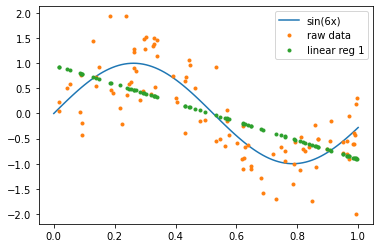

In [6]:
model = LinearRegression(1)
model.fit(X_train, y_train)

print(model.coefs)

plt.plot(x, y, label='sin(6x)')
plt.plot(X, Y, '.', label='raw data')
plt.plot(X_train, model.predict(X_train), '.', label='linear reg 1')
plt.legend()

### Fit avec des polynômes de degrés plus élevés ###
Comme on pouvait s'en douter le fit avec un polynôme de degré 1 est de mauvaise qualité, nous allons donc essayer de fitter ces données avec des polynômes de degrés plus élevés :


*** Exercice :*** Comment construire cette fois ci la matrice $X$ pour faire un fit avec un polynôme de degré arbitraire ? (indice dans l'exercice précédent on pouvait écire la ligne i de la forme $(x_i^0,x_i^1)$

***Exercice :*** Coder un algorithme pour fitter les données à un polynôme de degré entre 1 et 15, et tracer les résultats, que remarque-t-on sur les degrés les plus élevés ?

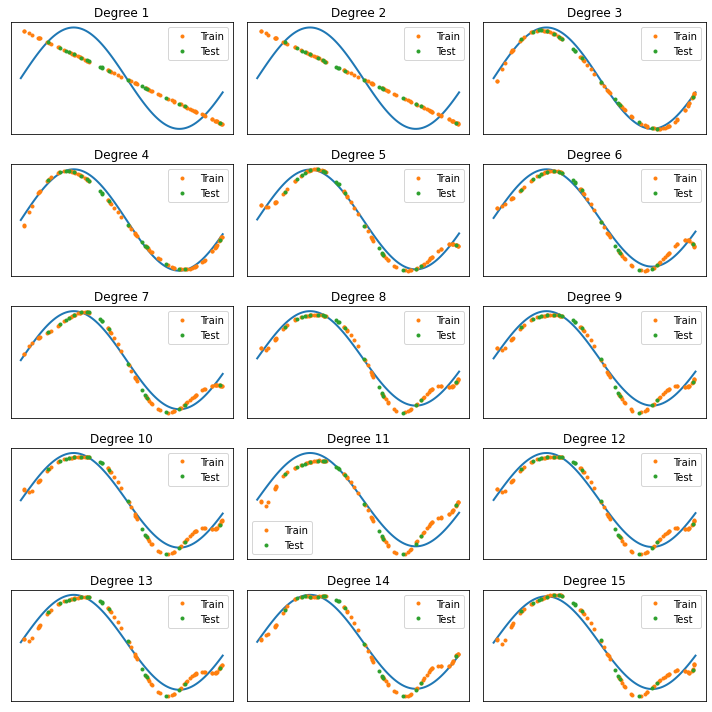

In [7]:
degree_max = 15

n_rows, n_columns = (int(degree_max / 3), 3)
fig, axes = plt.subplots(n_rows, n_columns, figsize=(10,10))

models = []

for k in range(degree_max):
    models.append(LinearRegression(k+1))
    models[k].fit(X_train, y_train)
    
    i, j = int(k / n_columns), k % n_columns
    axes[i][j].plot(x, y, linewidth=2)
    axes[i][j].plot(X_train, models[k].predict(X_train), '.', label='Train')
    axes[i][j].plot(X_test, models[k].predict(X_test), '.', label='Test')
    axes[i][j].set_title('Degree {:d}'.format(k+1))
    axes[i][j].xaxis.set_ticks([])
    axes[i][j].yaxis.set_ticks([])
    axes[i][j].legend()
    
fig.tight_layout()
plt.show()

***Exercice :*** Pour confirmer votre intuition, tracer la RMSE sur le l'ensemble d'entrainement et de test en fonction du degré du polynôme

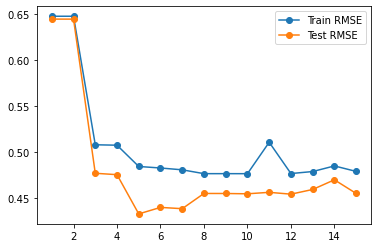

In [8]:
rmse = np.empty((degree_max, 2))
for k in range(degree_max):
    rmse[k, 0] = models[k].rmse(X_train, y_train)
    rmse[k, 1] = models[k].rmse(X_test, y_test)
    
plt.plot(range(1,degree_max+1), rmse[:,0], 'o-', label='Train RMSE')
plt.plot(range(1,degree_max+1), rmse[:,1], 'o-', label='Test RMSE')
plt.legend()

### Comment résoudre ce problème ? ###
Souvent pour éviter l'overfit, on utilise une "pénalité" qui dépend des coefficients. Cette pénalité est soit la norme $L^2$ (ridge) soit la norme $L^1$ (LASSO), nous allons implémenter ces deux méthodes pour le modèle que nous avons étudié précédemment.
#### Ridge regression ####
Pour la regression ridge, le risque s'écrit :


$$ R(w) = \sum_{i=1}^{n} (wx_i -y_i)^2 + \lambda \sum_{i=1}^{n} w_i^2$$

La solution du problème est alors (preuve en bonus à la fin) :
$$ \mathbf{w}_{ridge}= (\mathbf{X}^T\mathbf{X}+\lambda I)^{-1}\mathbf{X}^T \textbf{y}$$

***Exercice*** Coder un algorithme pour fitter les données à un polynôme de degré entre 1 et 15 avec ridge, et tracer les résultats

In [9]:
class RidgeLinearRegression(ABLR):
    
    def __init__(self, deg, l):
        self.l = l
        super().__init__(deg)
    
    def compute_fitting_matrix(self, X):
        size = np.shape(X)[1]
        return np.linalg.inv(X.T.dot(X) + self.l * np.identity(size)).dot(X.T)

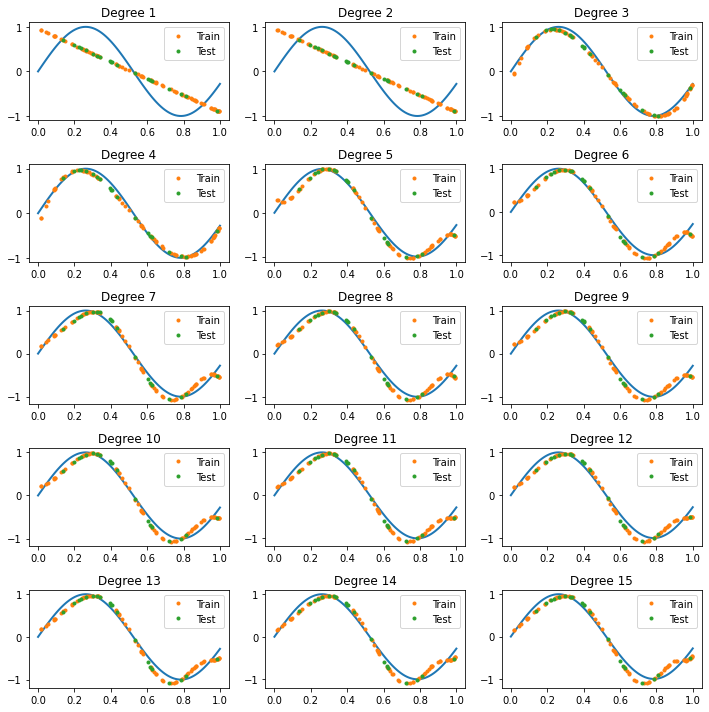

In [10]:
fig, axes = plt.subplots(n_rows, n_columns, figsize=(10,10))

l = 0.01
lambdas = np.logspace(-10, 10, 1000)

for k in range(degree_max):
    i, j = int(k / n_columns), k % n_columns
    axes[i][j].plot(x, y, linewidth=2)
    axes[i][j].set_title('Degree {:d}'.format(k+1))
    
    best_rmse, best_model = (100, None)
    
    for l in lambdas:
        model = RidgeLinearRegression(k+1, l)
        model.fit(X_train, y_train)
        
        rmse = model.rmse(X_test, y_test)
        if (rmse < best_rmse): best_rmse, best_model = (rmse, model)
        
    axes[i][j].plot(X_train, best_model.predict(X_train), '.', label='Train')
    axes[i][j].plot(X_test, best_model.predict(X_test), '.', label='Test')
    axes[i][j].legend()
    
fig.tight_layout()
plt.show()



## Numerical Experiments with Ridge Regression and LASSO##

Nous allons maintenant effectuer quelques expériences numériques avec la base de données sur le diabète en essayant de prédire l’évolution du diabète un an plus tard. Pour plus d'informations sur cet ensemble de données, voir <a href="https://archive.ics.uci.edu/ml/datasets/Diabetes"> https://archive.ics.uci.edu/ml/datasets/ Diabète </a>. Cet ensemble de données a été décrit dans le célèbre <a href="http://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf"> régression par le moindre angle </a> par Efron, Hastie, Johnstone, Tibshirani. comme suit:
<blockquote> Dix variables de base, l'âge, le sexe, l'indice de masse corporelle, la pression artérielle moyenne et six mesures de sérum sanguin ont été obtenus pour chacun des patients diabétiques à n $ = 442 $, ainsi que
réponse d'intérêt, une mesure quantitative de la progression de la maladie un an après le début de l'étude. 
Nous commençons par tracer les poids pour chaque valeur de $ \lambda $ pour Ridge Regression et LASSO. Cela s'appelle un chemin de régularisation. Nous comparons également les performances intra-échantillon et non échantillonné entre deux régressions en examinant le coefficient de détermination $ R ^ 2 $ (pour une définition détaillée, voir <a href = "https://en.wikipedia.org/wiki/ Coefficient_de_détermination "> ici </a>). En termes de régression linéaire, $ R ^ 2 $ nous indique dans quelle mesure la fonction de régression correspond aux données. Le meilleur ajustement possible correspond à $ R ^ 2 = 1 $.


 ***Exercice :*** Compléter le code suivant en utilisant la bibliothèque sklearn : placer pour chaque valeur de $\lambda$ (dans le tableau lambdas) les valeurs des coefficients calculés par méthode ridge et LASSO dans les tableaux coefs_ridge et coefs_lasso.

Automatically created module for IPython interactive environment


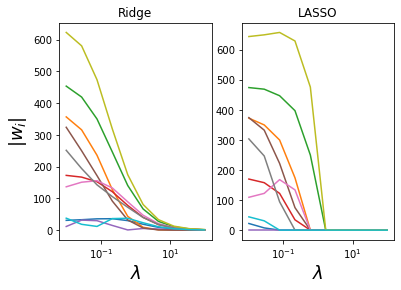

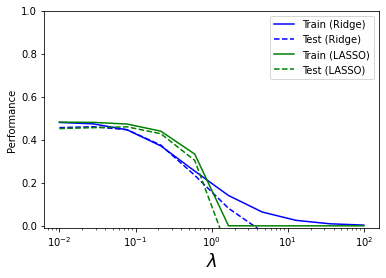

In [11]:
from __future__ import print_function
print(__doc__)

%matplotlib inline

# This code is modified from plot_cv_diabetes.py in the skit-learn documentation
# and plot_ridge_path.py


import numpy as np
import matplotlib.pyplot as plt
#import seaborn

from sklearn import datasets, linear_model

# Load Training Data set with 200 examples

number_examples=200
diabetes = datasets.load_diabetes()
X = diabetes.data[:number_examples]
y = diabetes.target[:number_examples]

# Set up Lasso and Ridge Regression models


# Chooose paths
lambdas = np.logspace(-2, 2, 10)

# To see how well we learn, we partition the dataset into a training set with 150 
# as well as a test set with 50 examples. We record their errors respectively.

n_samples = 150
n_samples_train = 100
X_train, X_test = X[:n_samples_train], X[n_samples_train:]
y_train, y_test = y[:n_samples_train], y[n_samples_train:]
train_errors_ridge = list()
test_errors_ridge = list()

train_errors_lasso = list()
test_errors_lasso = list()

# Initialize coeffficients for ridge regression and Lasso

coefs_ridge = []
coefs_lasso=[]
for a in lambdas:
###Code à insérer ici, les fonctions à trouver sont dans sklearn
    rr = linear_model.Ridge(a)
    rr.fit(X_train, y_train)
    coefs_ridge.append(rr.coef_)
    train_errors_ridge.append(rr.score(X_train, y_train))
    test_errors_ridge.append(rr.score(X_test, y_test))
    
    rl = linear_model.Lasso(a)
    rl.fit(X_train, y_train)
    coefs_lasso.append(rl.coef_)
    train_errors_lasso.append(rl.score(X_train, y_train))
    test_errors_lasso.append(rl.score(X_test, y_test))
    
###############################################################################
# Display results

# First see how the 10 features we learned scale as we change the regularization parameter
plt.subplot(1,2,1)
plt.semilogx(lambdas, np.abs(coefs_ridge))
axes = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel(r'$\lambda$',fontsize=18)
plt.ylabel('$|w_i|$',fontsize=18)
plt.title('Ridge')
#plt.savefig("Ridge_sparsity_scale.pdf.pdf")



plt.subplot(1,2,2)
plt.semilogx(lambdas, np.abs(coefs_lasso))
axes = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel(r'$\lambda$',fontsize=18)
#plt.ylabel('$|\mathbf{w}|$',fontsize=18)
plt.title('LASSO')
#plt.savefig("LASSO_sparsity_scale.pdf")
plt.show()


# Plot our performance on both the training and test data
plt.semilogx(lambdas, train_errors_ridge, 'b',label='Train (Ridge)')
plt.semilogx(lambdas, test_errors_ridge, '--b',label='Test (Ridge)')
plt.semilogx(lambdas, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lambdas, test_errors_lasso, '--g',label='Test (LASSO)')
#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='upper right')
plt.ylim([-0.01, 1.0])
plt.xlabel(r'$\lambda$',fontsize=18)
plt.ylabel('Performance')
#plt.savefig("Ridge_LASSO_sparsity_performance.pdf")
plt.show()

### QUESTIONS: ###  
<ul>
<li> À quoi correspondent les points $ \lambda = 0 $ et $ \lambda = 10 ^ 5 $? Est-ce étrange que les poids ne soient pas monotones dans $ \lambda $? Pourquoi pensez-vous que cela pourrait être?
<li> Quelle est la différence qualitative entre le chemin LASSO et le chemin Ridge? Est-ce que cela concorde avec vos prédictions antérieures? Pouvez-vous présenter un argument qualitatif pour rationaliser cette différence?
<li> En quoi vos réponses changent-elles lorsque vous modifiez le nombre d'exemples et la taille de l'ensemble de formation?
</ul>

# Le reseau elastique (Elastic-net)

La méthode Elastic-Net combine les atouts des méthodes Ridge et LASSO:

$$
\underset{\mathbf{w}\in\mathbb{R}^p}{\operatorname{min}} ||\mathbf{Xw}-\mathbf{y}||_2^2 + \lambda ||\mathbf{w}||_1 + \delta||\mathbf{w}||_2^2,
$$
où $ \lambda, \delta  $ sont des paramètres de régularisation. Désormais, mis à part le caractère unique de la solution, le réseau-élastique combine certaines des propriétés souhaitables (par exemple, la prédiction) de la régression de Ridge avec les propriétés de parcimonie du LASSO:

### Exercise : ###  
<ul>
<li> Jouez avec les paramètres $ \lambda $ et $ \delta $, quand vous attendriez-vous à des solutions rares?

<li> Tracez le chemin de régularisation du filet élastique. Comment cela dépend-il de $ \lambda $ et $ \delta $ (tracez un graphe de l'erreur en fonction de $\lambda$ et $\delta$)?

</ul>

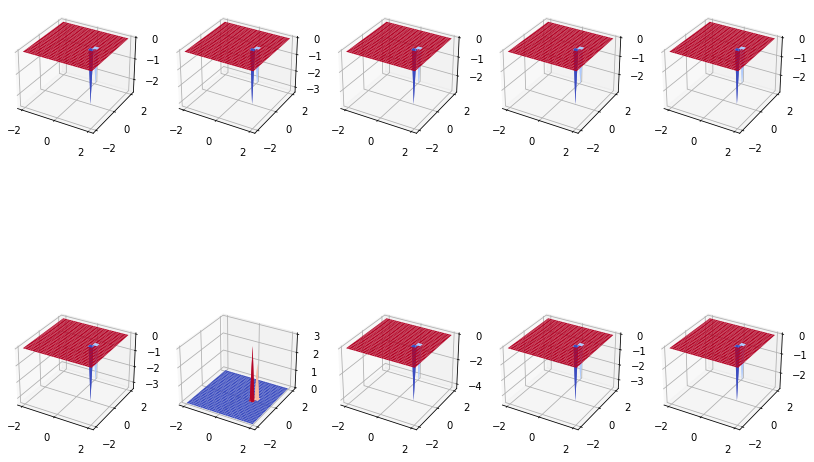

In [12]:
n_samples = 30

coefs_elasticnet = np.empty([n_samples, n_samples, 10])
train_errors_elasticnet = np.empty((n_samples, n_samples))
test_errors_elasticnet = np.empty((n_samples, n_samples))

values = np.linspace(-2, 2, n_samples)

i, j = (0, 0)

for l in values:
    for d in values:
        enr = linear_model.ElasticNet(l, d)
        enr.fit(X_train, y_train)
        coefs_elasticnet[i][j] = enr.coef_
        train_errors_elasticnet[i][j] = enr.score(X_train, y_train)
        test_errors_elasticnet[i][j] = enr.score(X_test, y_test)
        j += 1
    i += 1
    j = 0
    
###############################################################################
# Display results


X, Y = np.meshgrid(values, values)
fig = plt.figure(figsize=(14, 10))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, projection='3d')
    ax.plot_surface(X, Y, coefs_elasticnet[:,:,i], rstride=1, cstride=1, cmap=plt.cm.coolwarm)

plt.show()
#plt.subplot(222)
#plt.contour(X, Y, coefs_elasticnet[:,:,1], 8, alpha=.75, cmap=plt.cm.hot)
#plt.subplot(223)
#plt.contour(X, Y, coefs_elasticnet[:,:,2], 8, alpha=.75, cmap=plt.cm.hot)
#plt.subplot(224)
#plt.contour(X, Y, coefs_elasticnet[:,:,3], 8, alpha=.75, cmap=plt.cm.hot)

#ax.plot_surface(X, Y, coefs_elasticnet[0], rstride=1, cstride=1, cmap=plt.cm.coolwarm)
#ax.view_init(0, 0)

# First see how the 10 features we learned scale as we change the regularization parameter
#plt.subplot(1,2,1)
#plt.semilogx(values, np.abs(coefs_elasticnet[5]))
#axes = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
#plt.xlabel(r'$\lambda$',fontsize=18)
#plt.ylabel('$|w_i|$',fontsize=18)
#plt.title('Elastic Net')
#plt.savefig("Ridge_sparsity_scale.pdf.pdf")

#plt.subplot(1,2,2)
#plt.semilogx(values, np.abs(d_coefs_elasticnet[:][5]))
#axes = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
#plt.xlabel(r'$\delta$',fontsize=18)
#plt.ylabel('$|\mathbf{w}|$',fontsize=18)
#plt.title('Elastic Net')
#plt.savefig("LASSO_sparsity_scale.pdf")
#plt.show()

# Plot our performance on both the training and test data
#plt.subplot(1,2,1)
#plt.semilogx(values, l_train_errors_elasticnet, 'b',label='Train (ElasticNet)')
#plt.semilogx(values, l_test_errors_elasticnet, '--b',label='Test (ElasticNet)')
#plt.legend()
#plt.xlabel(r'$\lambda$',fontsize=18)
#plt.ylabel('Performance')

#plt.subplot(1,2,2)
#plt.semilogx(values, d_train_errors_elasticnet, 'g',label='Train (ElasticNet)')
#plt.semilogx(values, d_test_errors_elasticnet, '--g',label='Test (ElasticNet)')
#plt.legend()
#plt.xlabel(r'$\delta$',fontsize=18)
#plt.ylabel('Performance')

#plt.tight_layout()
#plt.show()

#### BONUS : LASSO regression ####
Pour LASSO, la tâche est un petit peu plus compliquée en effet, comme la dérivée du risque est un petit peu plus compliquée, il n'existe pas de explicite pour trouver les coefficients, nous allons procéder ensemble. L'algorithme s'appelle la descente de coordonnées. Nous avons la formule suivante :
$$w^i_{LASSO} = \dfrac  {S_{\lambda} ( X_i^T (y- X_{-i}w_{-i}))}{X_i^TX_i}$$
$X_i$ correspond à la colonne i de la matrice X, et $X_{-i}$ correspond à la matrice X à laquelle on a enlevée la colonne i, $w_{-i}$ correspond au vecteur i auquel on a enlevé l'élément i. Enfin $S_{\lambda}$ est une fonction appelée "soft threshold function" définie comme ceci :
$S_{\lambda}(x) = 0$ si $|x|<\lambda$ et $S_{\lambda}(x) = x-\lambda sign(x)$ sinon

*** Exercice *** Concevoir un algorithme, et tracer les résultats (indice : avec la formule précédente on a l'expression d'une coordonnée en fonction de toutes les autres, on peut donc procéder avec plusieurs itérations jusqu'à convergence)

In [13]:
###Mettre votre code ici ###

### Questions théoriques bonus ###  
<ul>

<li> Dérivez $ \hat {\textbf {w}} $ explicitement en résolvant le problème des moindres carrés défini ci-dessus.


<li> Est-ce que $ \hat {\textbf {w}} $ est toujours bien défini quand le rang $r(\mathbf {X})<p$? Cela se produit lorsque, par exemple, $ n<p $.

<li> Imaginons maintenant que les exemples soient générés de la manière suivante: $ y_i = \textbf {w} _ \text {true} \cdot \textbf {x} ^ {(i)} + \epsilon_i $ où les $ \epsilon_i \sim \mathcal {N} (0, \sigma ^ 2) $ sont iid Gaussiens. Le risque intra-échantillon est défini comme
$$
R (\hat {\textbf {w}}, \textbf {w} _ \text {true}) = \frac {1} {n} \mathbb {E} [(\mathbf {X} \hat {\textbf {w}} - \mathbf {X} {\textbf {w} _ \text {true}}) ^ 2],
$$
où $ \mathbb {E} [\cdots] $ est repris sur toutes les paires iid $ (y_i, \textbf {x} ^ {(i)}) $ et $ \hat {\textbf {w}} $ est le moins carrés solution donnée ci-dessus. En supposant que $ \mathbf {X} $ et $ \epsilon_i $ soient indépendants, montrez que le risque est donné par

$$
R (\hat {\textbf {w}}, \textbf {w} _ \text {true}) = \sigma ^ 2 \frac {p} {n}
$$
Quelle est l’implication de cela pour $ p $ fixe en tant que $ n \rightarrow \infty $? Qu'en est-il de quand $ p, n $ évolue ensemble?

</ul>

## Exercises pour RIDGE: ##

Dans la Ridge-Regression, la pénalité de régularisation est la norme L2 des paramètres
$$
\mathbf{w}_{ridge}(\lambda)= \underset{\textbf{w}\in\mathbb{R}^p}{\operatorname{argmin}} ||\mathbf{X}\textbf{w}-\textbf{y}||_2^2 + \lambda ||\textbf{w}||_2^2.
$$

Ainsi, le modèle est ajusté en minimisant la somme de l'erreur dans l'échantillon et du terme de régularisation
$$
\mathbf{w}_{ridge}(\lambda)= \underset{\textbf{w}\in\mathbb{R}^p}{\operatorname{argmin}} ||\mathbf{X}\textbf{w}-\textbf{y}||_2^2 + \lambda ||\textbf{w}||_2^2.
$$
Notez que le paramètre $ \lambda $ contrôle combien nous pesons le terme d’ajustement et de régularisation.

<ul>
<li>Montrer que la solution est donnée par $\mathbf{w}_{ridge}= (\mathbf{X}^T\mathbf{X}+\lambda I)^{-1}\mathbf{X}^T \textbf{y}$. 
<li>Exprimez votre réponse en termes de décomposition en valeurs singulières de $\mathbf{X}$.
</ul>

## Exercises pour LASSO ##

Nous nous intéresserons également au cas où la pénalité est la norme L1 des paramètres (somme des valeurs absolues des paramètres). Ceci s'appelle LASSO.
$$
E_{LASSO}= \lambda ||\mathbf{w}||_1 = \lambda \sum_{\gamma=1}^p |w_\gamma| .
$$
Dans ce cas,
$$
\textbf{w}_{LASSO}(\lambda)= \underset{\textbf{w}\in\mathbb{R}^p}{\operatorname{argmin}} {1 \over 2n} ||\mathbf{Xw}-\mathbf{y}||_2^2 + \lambda ||\mathbf{w}||_1.
$$
Notez que le préfacteur $ 1 / (2n) $ dans la fonction de perte n'est pas essentiel à cette formulation. Nous avons choisi cette forme pour être cohérente avec le package Scikit-Learn en Python. Comme nous en avons discuté en cours, LASSO a tendance à donner des solution parcimonieuses. 

<ul>
<li> Pouvez-vous dériver une expression analytique pour $ \mathbf {w} _ {LASSO} $? Avez-vous des idées sur la manière dont nous pourrions être en mesure de le calculer numériquement efficacement?
<li> Pensez-vous que LASSO et Ridge Regression donneront des réponses qualitativement différentes? (Considérez les limites $ \lambda = 0$ et $ \lambda = \infty $)
</ul>